In [12]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
community_embeddings = np.load('../../src/nlp/community_embeddings.npy', allow_pickle=True)
user_embeddings = np.load('../../src/nlp/user_embeddings.npy', allow_pickle=True)
users_role = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')

In [14]:
# Converting npy files into python dicts
users_role = users_role.loc[users_role['is_hub'] | users_role['is_bridge']]
user_emb_dict = {id_: emb for id_, emb in user_embeddings}
community_emb_dict = {id_: emb for id_, emb in community_embeddings}

# Adding embeddings to users dataframe
users_role['user_embedding'] = users_role['id'].map(user_emb_dict)
users_role['community_embedding'] = users_role['community_id'].map(community_emb_dict)

users_role.head()

,id,degree,internal_degree,community_id,community_type,external_degree,pct_internal,pct_external,is_hub,is_bridge,user_embedding,community_embedding
8,Crew_1996,9,7,0,Very Strong community,2,0.777778,0.222222,False,True,"[-0.0020248862996436, -0.04165101331363059, -0...","[0.00878261319496715, -0.0016162803461459067, ..."
9,DeltaBot,458,456,0,Very Strong community,2,0.995633,0.004367,True,False,"[-0.06983418083076673, -0.006019841997424151, ...","[0.00878261319496715, -0.0016162803461459067, ..."
10,Destinyciello,198,191,0,Very Strong community,7,0.964646,0.035354,True,False,"[0.012977522255776093, -0.005824940119110212, ...","[0.00878261319496715, -0.0016162803461459067, ..."
14,LucidMetal,71,69,0,Very Strong community,2,0.971831,0.028169,True,False,"[0.036776777402636934, -0.0008747445986793191,...","[0.00878261319496715, -0.0016162803461459067, ..."
17,Rough-Tension,18,12,0,Very Strong community,6,0.666667,0.333333,False,True,"[0.015944050412294533, -0.01255399286146912, 0...","[0.00878261319496715, -0.0016162803461459067, ..."


In [15]:
def compute_cosine_similarity(user_id):
    user = users_role[users_role['id'] == user_id]

    user_emb = np.array(user['user_embedding'].iloc[0]).reshape(1, -1)
    user_comm_emb = np.array(user['community_embedding'].iloc[0]).reshape(1, -1)

    similarity = cosine_similarity(user_emb, user_comm_emb)[0][0]

    return similarity

users_role['similarity'] = users_role['id'].apply(compute_cosine_similarity)
users_role.loc[users_role['is_hub']].head()

,id,degree,internal_degree,community_id,community_type,external_degree,pct_internal,pct_external,is_hub,is_bridge,user_embedding,community_embedding,similarity
9,DeltaBot,458,456,0,Very Strong community,2,0.995633,0.004367,True,False,"[-0.06983418083076673, -0.006019841997424151, ...","[0.00878261319496715, -0.0016162803461459067, ...",0.311300
10,Destinyciello,198,191,0,Very Strong community,7,0.964646,0.035354,True,False,"[0.012977522255776093, -0.005824940119110212, ...","[0.00878261319496715, -0.0016162803461459067, ...",0.878634
14,LucidMetal,71,69,0,Very Strong community,2,0.971831,0.028169,True,False,"[0.036776777402636934, -0.0008747445986793191,...","[0.00878261319496715, -0.0016162803461459067, ...",0.930287
21,Thumatingra,63,62,0,Very Strong community,1,0.984127,0.015873,True,False,"[0.010650161314749707, -0.013414646267115228, ...","[0.00878261319496715, -0.0016162803461459067, ...",0.875703
32,-Papa-Smurf,42,38,2,Strong community,4,0.904762,0.095238,True,False,"[-0.007356688748378776, 0.017635595000507435, ...","[-0.06378324591227912, 0.04083870989192552, 0....",0.645051


In [16]:
users_role.to_csv('users_similarity.csv', sep=',', encoding='utf-8', index=False)

In [17]:
users_role.loc[users_role['is_hub']]['similarity'].agg(('count', 'mean', 'median', 'std'), axis=0)

count     714.000000
mean        0.784978
median      0.825895
std         0.134328
Name: similarity, dtype: float64

In [18]:
hub_sim_list = users_role.loc[users_role['is_hub']]['similarity']
hub_sim = pd.Series(hub_sim_list)

In [19]:
users_role.loc[users_role['is_bridge']]['similarity'].agg(('count', 'mean', 'median', 'std'), axis=0)

count     1844.000000
mean         0.736210
median       0.749849
std          0.108980
Name: similarity, dtype: float64

In [20]:
bridge_sim_list = users_role.loc[users_role['is_bridge']]['similarity']
bridge_sim = pd.Series(bridge_sim_list)

In [21]:
# Assumendo che hub_sim e bridge_sim siano Series con le similarità
# 1. Test di normalità
print("Shapiro Hub:", shapiro(hub_sim))
print("Shapiro Bridge:", shapiro(bridge_sim))

# 2. Test di omogeneità delle varianze
print("Levene:", levene(hub_sim, bridge_sim))

# 3. Scegli il test in base ai risultati
if shapiro(hub_sim).pvalue > 0.05 and shapiro(bridge_sim).pvalue > 0.05:
    # Normali
    if levene(hub_sim, bridge_sim).pvalue > 0.05:
        # Varianze uguali
        print("T-test:", ttest_ind(hub_sim, bridge_sim))
    else:
        # Varianze diverse
        print("T-test var unequal:", ttest_ind(hub_sim, bridge_sim, equal_var=False))
else:
    # Non normali → Mann-Whitney
    print("Mann-Whitney:", mannwhitneyu(hub_sim, bridge_sim, alternative='two-sided'))


Shapiro Hub: ShapiroResult(statistic=np.float64(0.9133202941174634), pvalue=np.float64(9.217089739669632e-20))
Shapiro Bridge: ShapiroResult(statistic=np.float64(0.974682302952184), pvalue=np.float64(1.5752760955968185e-17))
Levene: LeveneResult(statistic=np.float64(45.06406800911444), pvalue=np.float64(2.340748380878223e-11))
Mann-Whitney: MannwhitneyuResult(statistic=np.float64(842830.0), pvalue=np.float64(3.338653692800594e-28))


/tmp/ipykernel_8689/1779058704.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([hub_data, bridge_data], labels=["Hub", "Bridge"])


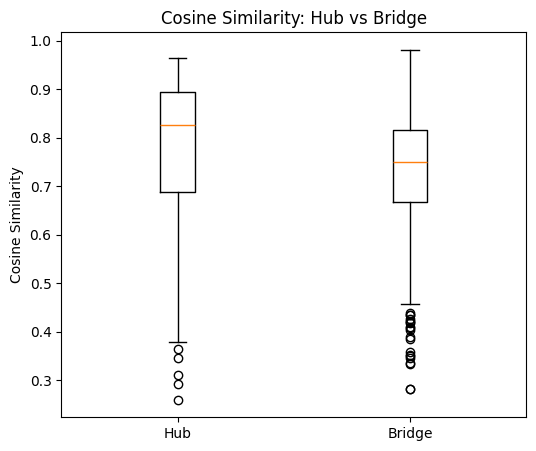

In [22]:
hub_data = pd.Series(name="Hub", data=hub_sim)  
bridge_data = pd.Series(name="Bridge", data=bridge_sim)  

# Creazione del boxplot
fig, ax = plt.subplots(figsize=(6, 5))
ax.boxplot([hub_data, bridge_data], labels=["Hub", "Bridge"])
ax.set_title("Cosine Similarity: Hub vs Bridge")
ax.set_ylabel("Cosine Similarity")
plt.show()
